In [1]:
import os
import sys
import shutil

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

ROOT_PATH = os.getcwd()
if "/kaggle" in ROOT_PATH:
    ROOT_PATH = "/kaggle/input"
    sys.path.append(os.path.join(ROOT_PATH, "map-utilities"))

In [2]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

import torch
from datasets import Dataset
from peft import (
    get_peft_model,
    LoraConfig,
    TaskType,
    prepare_model_for_kbit_training,
    PeftModel,
)

from utils import (
    stringify_input,
    get_model_name,
    get_sequence_classifier,
    get_tokenizer,
    get_training_arguments,
    get_trainer,
    convert_latex_to_text,
)

In [3]:
# BASE_MODEL = "microsoft/deberta-v3-large"
# BASE_MODEL = "answerdotai/ModernBERT-large"
# BASE_MODEL = "jhu-clsp/ettin-encoder-1b"
BASE_MODEL = "google/gemma-2-2b-it"
# BASE_MODEL = "google/gemma-2-9b-it"
# BASE_MODEL = "Qwen/Qwen3-1.7B"
# BASE_MODEL = "Qwen/Qwen3-8B"
# BASE_MODEL = "Qwen/Qwen3-14B"
# BASE_MODEL = "Qwen/Qwen2.5-Math-1.5B-Instruct"
# BASE_MODEL = "Qwen/Qwen2.5-Math-7B-Instruct"
# BASE_MODEL = "Qwen/Qwen2.5-Coder-14B-Instruct"
# BASE_MODEL = "deepseek-ai/deepseek-math-7b-instruct"
# BASE_MODEL = "deepseek-ai/DeepSeek-R1-0528-Qwen3-8B"
# BASE_MODEL = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
# BASE_MODEL = "Qwen/Qwen3-Embedding-4B"
# BASE_MODEL = "Qwen/Qwen3-Embedding-8B"
# BASE_MODEL = "nvidia/AceMath-1.5B-Instruct"
# BASE_MODEL = "nvidia/AceReason-Nemotron-1.1-7B"
# BASE_MODEL = "nvidia/AceReason-Nemotron-14B"
# BASE_MODEL = "meta-llama/Llama-3.1-8B-Instruct"
# BASE_MODEL = "meta-llama/Llama-3.2-1B-Instruct"
# BASE_MODEL = "google/t5gemma-l-l-ul2-it"
# BASE_MODEL = "google/t5gemma-2b-2b-ul2-it"
# BASE_MODEL = "google/t5gemma-9b-2b-ul2-it"
# BASE_MODEL = "google/gemma-3-1b-it"
# BASE_MODEL = "google/gemma-3-12b-it"

SPLIT_RATIO = 0.2
MAX_LEN = 256
EPOCHS = 3
LEARNING_RATE = 4e-5
BATCH_SIZE = 16
MODEL_NAME = get_model_name("/kaggle" in ROOT_PATH, ROOT_PATH, BASE_MODEL)
NEW_PROMPT = False

TRAIN_ON_FULL_DATASET = False
if TRAIN_ON_FULL_DATASET:
    EPOCHS = 1

USE_LORA = False
USE_QLORA = False
BITS = 4
USE_4BIT = BITS == 4
USE_8BIT = BITS == 8

TRAIN_PATH = os.path.join(ROOT_PATH, "map-charting-student-math-misunderstandings", "train.csv")
TEST_PATH = os.path.join(ROOT_PATH, "map-charting-student-math-misunderstandings", "test.csv")

In [4]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

In [5]:
print("Training Shape:", train_df.shape)
print("Testing Shape:", test_df.shape)

Training Shape: (36696, 7)
Testing Shape: (3, 5)


In [6]:
train_df.Misconception = train_df.Misconception.fillna("NA")
train_df["predict"] = train_df.Category + ":" + train_df.Misconception

In [7]:
idx = train_df.Category.str.contains("True", case=False)
tmp = train_df.loc[idx].copy()
tmp["c"] = tmp.groupby(["QuestionId", "MC_Answer"]).MC_Answer.transform("count")
tmp = tmp.sort_values("c", ascending=False)
tmp = tmp.drop_duplicates(["QuestionId"])
tmp = tmp[["QuestionId", "MC_Answer"]]
tmp["is_mc_answer_correct"] = True

train_df = train_df.merge(tmp, on=["QuestionId", "MC_Answer"], how="left")
train_df.is_mc_answer_correct = train_df.is_mc_answer_correct.fillna(False)

test_df = test_df.merge(tmp, on=["QuestionId", "MC_Answer"], how="left")
test_df.is_mc_answer_correct = test_df.is_mc_answer_correct.fillna(False)

/tmp/ipykernel_1945788/1307861462.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df.is_mc_answer_correct = train_df.is_mc_answer_correct.fillna(False)
/tmp/ipykernel_1945788/1307861462.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df.is_mc_answer_correct = test_df.is_mc_answer_correct.fillna(False)


In [8]:
train_df["is_student_explanation_correct"] = train_df.Category.apply(
    lambda x: 0 if "Neither" in x else (1 if "Correct" in x else 2)
)

In [9]:
# le = LabelEncoder()
le = joblib.load(os.path.join(ROOT_PATH, "label_encoder.joblib"))

train_df["label"] = le.transform(train_df["predict"])
n_classes = len(le.classes_)
print(f"Train shape: {train_df.shape} with {n_classes} predict classes")

Train shape: (36696, 11) with 65 predict classes


/home/ubuntu/map-kaggle-competition/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [10]:
# joblib.dump(le, "label_encoder.joblib")

In [11]:
train_df.head()

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception,predict,is_mc_answer_correct,is_student_explanation_correct,label
0,0,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NA,True_Correct:NA,True,1,37
1,1,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,True_Correct,NA,True_Correct:NA,True,1,37
2,2,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"1 3rd is half of 3 6th, so it is simplee to un...",True_Neither,NA,True_Neither:NA,True,0,64
3,3,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 goes into everything and 3 goes into nine,True_Neither,NA,True_Neither:NA,True,0,64
4,4,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 out of every 3 isn't coloured,True_Correct,NA,True_Correct:NA,True,1,37


In [12]:
train_df.QuestionText.apply(convert_latex_to_text).unique()

array(['What fraction of the shape is not shaded? Give your answer in its simplest form. [Image: A triangle split into 9 equal smaller triangles. 6 of them are shaded.]',
       'Calculate ( (1)/(2) / 6 )',
       'A box contains ( 120 ) counters. The counters are red or blue. ( (3)/(5) ) of the counters are red.\nHow many red counters are there?',
       '( (A)/(10)=(9)/(15) ) What is the value of ( A ) ?',
       '( 2 y=24 ) What is the value of ( y ) ?',
       'Calculate ( (2)/(3) x 5 )', 'Which number is the greatest?',
       'A bag contains ( 24 ) yellow and green balls. ( (3)/(8) ) of the balls are yellow. How many of the balls are green?',
       '( (1)/(3)+(2)/(5)= )',
       'Sally has ( (2)/(3) ) of a whole cake in the fridge. Robert eats ( (1)/(3) ) of this piece. What fraction of the whole cake has Robert eaten?\nChoose the number sentence that would solve the word problem.',
       'This is part of a regular polygon. How many sides does it have? [Image: A diagram showing

In [13]:
train_df.MC_Answer.apply(convert_latex_to_text).unique()

array(['( (1)/(3) )', '( (3)/(6) )', '( (3)/(8) )', '( (3)/(9) )',
       '( 3 )', '( (1)/(12) )', '( (6)/(2) )', '( 24 )', '( 48 )',
       '( 60 )', '( 72 )', '( 4 )', '( 6 )', '( 9 )', '( 12 )', '( 22 )',
       '( 3 (1)/(3) )', '( 5 (2)/(3) )', '( (10)/(15) )', '( (2)/(15) )',
       '( 6.0001 )', '( 6.079 )', '( 6.2 )', '( 15 )', '( 8 )',
       '( (11)/(15) )', '( (11)/(30) )', '( (3)/(15) )',
       '( (1)/(3) x (2)/(3) )', '( (1)/(3)+(2)/(3) )',
       '( (2)/(3) / (1)/(3) )', '( (2)/(3)-(1)/(3) )',
       'Not enough information', '( 10 )', '( 5 )', '( -13 )', '( -3 )',
       '( 13 )', '( 20 )', '( 26 )', '( 36 )', '( 192 ) hours',
       '( 48 ) hours', '( 64 ) hours', '( 768 ) hours', 'Certain',
       'Impossible', 'Likely', 'Unlikely'], dtype=object)

In [14]:
if TRAIN_ON_FULL_DATASET:
    model_train_df = train_df.copy()
    model_val_df = train_df.copy()
else:
    model_train_df, model_val_df = train_test_split(train_df, test_size=SPLIT_RATIO, random_state=42)

In [15]:
model_train_df["stringified_input"] = model_train_df.apply(
    lambda row: stringify_input(row, MODEL_NAME, NEW_PROMPT), axis=1
)

model_train_df.stringified_input.values[:5]

array(["Question: Dots have been arranged in these patterns: [Image: Pattern 1 consists of 6 dots, Pattern 2 consists of 10 dots, Pattern 3 consists of 14 dots and Pattern 4 consists of 18 dots] How many dots would there be in Pattern ( 6 ) ?\nAnswer: ( 26 )\nCorrect? Yes\nStudent's Explanation: apart from the first it add's 4 every time",
       "Question: What fraction of the shape is not shaded? Give your answer in its simplest form. [Image: A triangle split into 9 equal smaller triangles. 6 of them are shaded.]\nAnswer: ( (3)/(9) )\nCorrect? No\nStudent's Explanation: There are 9 triangles and 3 arent shaded so this means it would be 9/3.",
       "Question: Dots have been arranged in these patterns: [Image: Pattern 1 consists of 6 dots, Pattern 2 consists of 10 dots, Pattern 3 consists of 14 dots and Pattern 4 consists of 18 dots] How many dots would there be in Pattern ( 6 ) ?\nAnswer: ( 36 )\nCorrect? No\nStudent's Explanation: i think this because its always in 4",
       "Ques

In [16]:
model_train_df.shape

(29356, 12)

In [17]:
# model_val_df.drop(columns=["is_student_explanation_correct"], inplace=True)
model_val_df["stringified_input"] = model_val_df.apply(
    lambda row: stringify_input(row, MODEL_NAME, NEW_PROMPT), axis=1
)

model_val_df.stringified_input.values[:5]

array(['Question: The probability of an event occurring is ( 0.9 ).\n\nWhich of the following most accurately describes the likelihood of the event occurring?\nAnswer: Likely\nCorrect? Yes\nStudent\'s Explanation: i think it\'s b because if it\'s certain, you\'re saying that it will happen 100%;however, the number is 0.9 and it isn\'t "certain" so therefore it would be likely',
       "Question: Sally has ( (2)/(3) ) of a whole cake in the fridge. Robert eats ( (1)/(3) ) of this piece. What fraction of the whole cake has Robert eaten?\nChoose the number sentence that would solve the word problem.\nAnswer: ( (2)/(3)-(1)/(3) )\nCorrect? No\nStudent's Explanation: roberts takes half of the 2/3 so it is -",
       "Question: Calculate ( (2)/(3) x 5 )\nAnswer: ( 3 (1)/(3) )\nCorrect? Yes\nStudent's Explanation: 2 x 5 is 10 so its 10/3 and 10/3 is also 3 1/3",
       "Question: Which number is the greatest?\nAnswer: ( 6.2 )\nCorrect? Yes\nStudent's Explanation: because it is 6.2 not 6   6.07

In [18]:
model_val_df.shape

(7340, 12)

In [19]:
COLUMNS = ["stringified_input", "label"]

train_ds = Dataset.from_pandas(model_train_df[COLUMNS])
val_ds = Dataset.from_pandas(model_val_df[COLUMNS])

In [20]:
if USE_LORA:
    R = 8
    lora_config = LoraConfig(
        r=R,
        lora_alpha=R*4,
        target_modules=[
            "q_proj", "k_proj", "v_proj", "o_proj",
            "down_proj", "up_proj", "gate_proj",
            # "embed_tokens", "lm_head",
        ],
        lora_dropout=0.1,
        task_type=TaskType.SEQ_CLS,
        inference_mode=False,
        # modules_to_save=["classifier"],
    )

q_lora_config = {
    "torch_dtype": torch.bfloat16
}
if USE_QLORA:
    from transformers import BitsAndBytesConfig

    kwargs = {}
    if USE_4BIT:
        kwargs = {
            "load_in_4bit": True,
            "bnb_4bit_quant_type": "nf4",
            "bnb_4bit_compute_dtype": torch.bfloat16,
            "bnb_4bit_use_double_quant": True,
            "bnb_4bit_quant_storage": torch.bfloat16,
        }
    if USE_8BIT:
        kwargs = {
            "load_in_8bit": True,
        }

    bnb_config = BitsAndBytesConfig(**kwargs)
    q_lora_config["quantization_config"] = bnb_config

In [21]:
seq_model = get_sequence_classifier(MODEL_NAME, n_classes, q_lora_config)
tokenizer = get_tokenizer(MODEL_NAME)

if (
    "gemma" in MODEL_NAME.lower()
    or "qwen" in MODEL_NAME.lower()
    or "deepseek-math" in MODEL_NAME.lower()
    or "llama-3.1" in MODEL_NAME.lower()
    or "llama-3.2" in MODEL_NAME.lower()
    or "acemath" in MODEL_NAME.lower()
):
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        tokenizer.pad_token_id = tokenizer.eos_token_id
    seq_model.config.pad_token_id = tokenizer.pad_token_id

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of Gemma2ForSequenceClassification were not initialized from the model checkpoint at google/gemma-2-2b-it and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
if USE_QLORA:
    seq_model = prepare_model_for_kbit_training(seq_model)

if USE_LORA:
    seq_model = get_peft_model(seq_model, lora_config)
    # seq_model = PeftModel.from_pretrained(seq_model, LORA_ADAPTER, is_trainable=True, config=lora_config)

In [23]:
def tokenize_function(examples):
    return tokenizer(examples["stringified_input"])

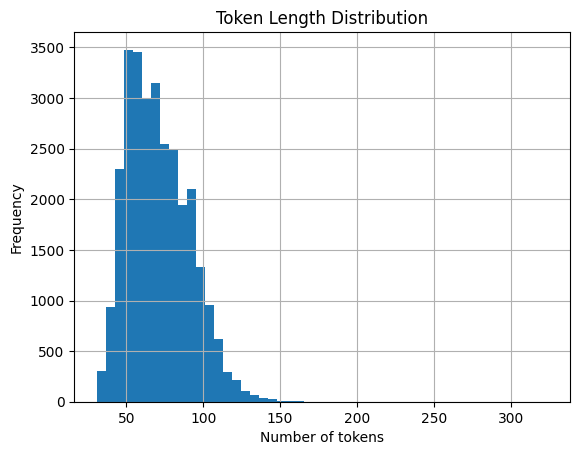

In [24]:
lengths = [len(tokenizer.encode(t, truncation=False)) for t in train_ds["stringified_input"]]

plt.hist(lengths, bins=50)
plt.title("Token Length Distribution")
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [25]:
L = (np.array(lengths) > MAX_LEN).sum()
print(f"There are {L} train sample(s) with more than {MAX_LEN} tokens")
np.sort(lengths)[::-1]

There are 1 train sample(s) with more than 256 tokens


array([324, 230, 189, ...,  31,  31,  31], shape=(29356,))

In [26]:
train_ds = train_ds.map(tokenize_function, batched=True)
val_ds = val_ds.map(tokenize_function, batched=True)

columns = ['input_ids', 'attention_mask', 'label']
train_ds.set_format(type='torch', columns=columns)
val_ds.set_format(type='torch', columns=columns)

Map:   0%|          | 0/29356 [00:00<?, ? examples/s]

Map:   0%|          | 0/7340 [00:00<?, ? examples/s]

In [27]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label'].to_numpy()
)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

In [28]:
training_args = get_training_arguments(
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS,
    train_batch_size=BATCH_SIZE,
    eval_batch_size=BATCH_SIZE*2,
    bf16_support="/kaggle" not in ROOT_PATH,
    train_on_full_dataset=TRAIN_ON_FULL_DATASET,
)
trainer = get_trainer(
    seq_model,
    tokenizer,
    training_args,
    train_ds,
    val_ds,
    train_on_full_dataset=TRAIN_ON_FULL_DATASET,
    # class_weights=class_weights_tensor,
)

/home/ubuntu/map-kaggle-competition/src/utils.py:226: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  return Trainer(


In [ ]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 1}.


Step,Training Loss,Validation Loss,Map@3
500,0.701100,0.695216,0.870936


In [ ]:
logs = pd.DataFrame(trainer.state.log_history)
train_loss = logs[logs["loss"].notna()][["step", "loss"]]

if not TRAIN_ON_FULL_DATASET:
    eval_loss = logs[logs["eval_loss"].notna()][["step", "eval_loss"]]

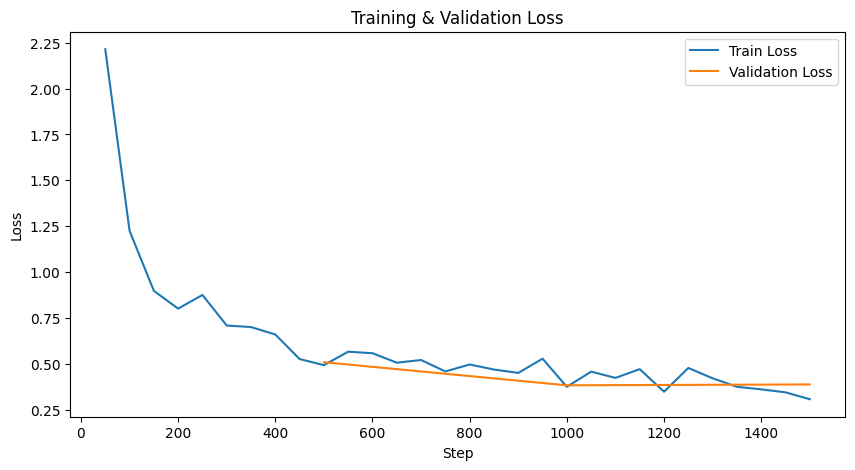

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss["step"], train_loss["loss"], label="Train Loss")
if not TRAIN_ON_FULL_DATASET:
    plt.plot(eval_loss["step"], eval_loss["eval_loss"], label="Validation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

In [ ]:
# trained_model = trainer.model
# merged_model = trained_model.merge_and_unload()
# merged_model.save_pretrained(f"best_model/{MODEL_NAME.replace('/', '-')}")

In [ ]:
best_model_path = f"best_model/{MODEL_NAME.replace('/', '-')}"

if os.path.exists(os.path.join(ROOT_PATH, best_model_path)):
    shutil.rmtree(os.path.join(ROOT_PATH, best_model_path))

trainer.save_model(best_model_path)
tokenizer.save_pretrained(best_model_path)

('best_model/jhu-clsp-ettin-encoder-1b/tokenizer_config.json',
 'best_model/jhu-clsp-ettin-encoder-1b/special_tokens_map.json',
 'best_model/jhu-clsp-ettin-encoder-1b/tokenizer.json')

In [ ]:
test_df.head()

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,is_mc_answer_correct
0,36696,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"I think that 1/3 is the answer, as it's the si...",True
1,36697,31772,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),i think this answer is because 3 triangles are...,False
2,36698,32835,Which number is the greatest?,\( 6.2 \),because the 2 makes it higher than the others.,True


In [ ]:
test_df["stringified_input"] = test_df.apply(
    lambda row: stringify_input(row, MODEL_NAME, NEW_PROMPT), axis=1
)
test_df.head()

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,is_mc_answer_correct,stringified_input
0,36696,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"I think that 1/3 is the answer, as it's the si...",True,Mathematical Problem Analysis:\n\nQuestion: Wh...
1,36697,31772,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),i think this answer is because 3 triangles are...,False,Mathematical Problem Analysis:\n\nQuestion: Wh...
2,36698,32835,Which number is the greatest?,\( 6.2 \),because the 2 makes it higher than the others.,True,Mathematical Problem Analysis:\n\nQuestion: Wh...


In [ ]:
test_df["stringified_input"].values[:5]

array(["Mathematical Problem Analysis:\n\nQuestion: What fraction of the shape is not shaded? Give your answer in its simplest form. [Image: A triangle split into 9 equal smaller triangles. 6 of them are shaded.]\nStudent Answer: ( (1)/(3) ) (This answer is correct)\nStudent Reasoning: I think that 1/3 is the answer, as it's the simplest form of 3/9.\n\nTask: Identify the specific misconception or confirm correct understanding.\n\nCommon misconceptions in this area include:\n- Arithmetic errors\n- Conceptual misunderstandings\n- Procedural mistakes\n- Misapplication of rules\n\nStudent's misconception category:",
       "Mathematical Problem Analysis:\n\nQuestion: What fraction of the shape is not shaded? Give your answer in its simplest form. [Image: A triangle split into 9 equal smaller triangles. 6 of them are shaded.]\nStudent Answer: ( (3)/(6) ) (This answer is incorrect)\nStudent Reasoning: i think this answer is because 3 triangles are white and 6 triangle are blue.\n\nTask: Ide

In [ ]:
test_ds = Dataset.from_pandas(test_df[["stringified_input"]])
test_ds = test_ds.map(tokenize_function, batched=True)

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

In [ ]:
predictions = trainer.predict(test_ds)
probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

In [ ]:
top3 = np.argsort(-probs, axis=1)[:, :3]

# Decode numeric class indices to original string labels
flat_top3 = top3.flatten()
decoded_labels = le.inverse_transform(flat_top3)
top3_labels = decoded_labels.reshape(top3.shape)

# Join 3 labels per row with space
joined_preds = [" ".join(row) for row in top3_labels]

# Save submission
sub = pd.DataFrame({
    "row_id": test_df.row_id.values,
    "Category:Misconception": joined_preds
})
sub.to_csv("submission.csv", index=False)
sub.head()

,row_id,Category:Misconception
0,36696,True_Correct:NA True_Neither:NA True_Misconcep...
1,36697,False_Misconception:WNB False_Neither:NA False...
2,36698,True_Correct:NA True_Neither:NA True_Misconcep...
